In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.use_deterministic_algorithms(True)

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Feb 22 2025

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

torchvision: 0.18.0
numpy      : 1.26.4
matplotlib : 3.9.0
torch      : 2.3.0

Watermark: 2.4.3



In [3]:
INPUT_DIR = 'data/hymenoptera_data'
IMAGENET_MEAN = np.array([0.490, 0.449, 0.411])
IMAGENET_STD = np.array([0.231, 0.221, 0.230])
BATCH_SIZE = 8
# Data normalization and augmentation transformations for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the mean of all pixel values for all images in the training set per each image channel - R, G and B

data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])}

dataset = {k: datasets.ImageFolder(os.path.join(INPUT_DIR, k), data_transformers[k]) for k in ['train', 'val']}
dataloader = {k: torch.utils.data.DataLoader(dataset[k], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 
            for k in ['train', 'val']}
dataset_size = {x: len(dataset[x]) for x in ['train', 'val']}
dataset_classes = dataset['train'].classes
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE, type(DEVICE))

cuda:0 <class 'torch.device'>


In [4]:
import ast
with open('./data/imagenet1000_clsidx_to_labels.txt') as f:
    classes_data = f.read()
classes_dict = ast.literal_eval(classes_data)
print({k: classes_dict[k] for k in list(classes_dict)[:5]})

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark'}


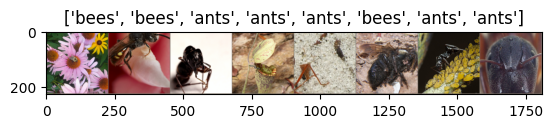

In [5]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
imgs, cls = next(iter(dataloader['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[dataset_classes[c] for c in cls])

In [6]:
def get_batches(dataloader, num_of_batches=3):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

def show_batches(images, classes):
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    images = images * IMAGENET_STD + IMAGENET_MEAN
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=20)
    plt.tight_layout()
    plt.show()

In [7]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dataloader['val']):
            imgs = imgs.to(DEVICE)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes_dict[int(preds[j])]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [8]:
model = models.vgg13(pretrained=True) 
model.to(DEVICE)

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

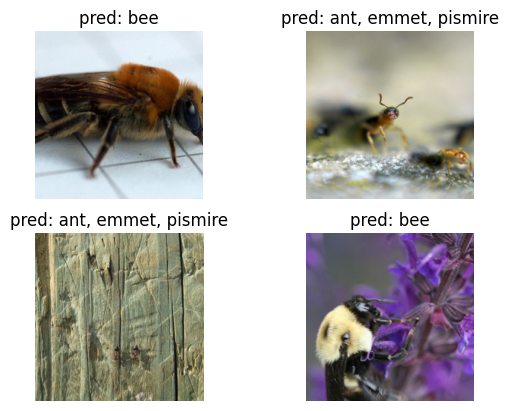

In [9]:
visualize_predictions(model, max_num_imgs=4)